In [5]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from timeit import default_timer as timer
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
#Set GPU Allocation
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1740578317.588771   12239 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## START OF THE TRAINING PROCESS

In [6]:
# Define the base directory
# Rice Bran
base_dir_rb = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 3'
#base_dir_rb = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Training and Validation/Set 4'

# Define the subdirectories for each type
pure_rb_dir = os.path.join(base_dir_rb, 'Pure')
adulterated_rb_dir = os.path.join(base_dir_rb, 'Adulterated')

# Soybean Meal
base_dir_sbm = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 2'
#base_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 1'
#base_dir_sbm = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Training and Validation/Set 3'

# Define the subdirectories for each type
pure_sbm_dir = os.path.join(base_dir_sbm, 'Pure')
adulterated_sbm_dir = os.path.join(base_dir_sbm, 'Adulterated')

# Corn
base_dir_corn = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Training and Validation/Set 2'
#base_dir_corn = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Training and Validation/Set 3'

# Define the subdirectories for each type
pure_corn_dir = os.path.join(base_dir_corn, 'Pure')
adulterated_corn_dir = os.path.join(base_dir_corn, 'Adulterated')


# image_path = os.path.join(adulterated_rb_dir, 'Adulterated_original_image (13).jpg_4a486883-be2c-414c-9d5e-0545d28807d8.jpg')
# img = mpimg.imread(image_path)
# print(img.shape)
# plt.imshow(img)
# plt.show()


### Data Splitting

In [7]:
def split_data(base_dir):
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='training',
        seed = 123,
        label_mode='binary',
        image_size=(224, 224),
        batch_size=32,
    )

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='validation',
        seed = 123,
        label_mode='binary',
        image_size=(224, 224),
        batch_size=32,
    )

    # class_names = train_ds.class_names
    # print(class_names)

    return [train_ds, validation_ds]

#### Training Process With Different Types of CNN Architecture

In [8]:
def train_data(model_type, epoch, lr, train_ds, validation_ds, p):
    start = timer()

    # Custom CNN Model
    model = model_type
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=p,          # Number of epochs with no improvement to wait
        restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
    )

    model_history = model.fit(
        x=train_ds, 
        validation_data=validation_ds, 
        epochs=epoch,
        callbacks=[early_stopping]  # Add EarlyStopping callback
    )

    print('Total Time consumed for ' + str(model_history.epoch[-1] + 1) + ' --->', timer()-start) #Corrects epoch count

    return model_history

#### Test Process With Different CNN Architecture

In [9]:
def test_set(test_dir):
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        image_size=(224, 224),
        batch_size=32,
        label_mode='binary',
        shuffle=False
    )

    return test_ds

def evaluate_model(model, test_ds, feed_type):
    # Evaluate the model on the test dataset
    test_loss, test_accuracy = model.evaluate(test_ds)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')

    # Generate predictions
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    y_pred = (y_pred > 0.5).astype(int)  # For binary classification

    # Compute evaluation metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=["Adulterated", "Pure"]))

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Adulterated', 'Pure'], yticklabels=['Adulterated', 'Pure'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix ({feed_type})')
    plt.show()

#### Base Directories of each ingredients

In [10]:
# Training Set
rb_data = split_data(base_dir_rb)
sbm_data = split_data(base_dir_sbm)
corn_data = split_data(base_dir_corn)

# Testing Dataset Directory
# Rice Bran
test_dir_rb = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 3')
#test_dir = '/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 2'
#test_dir_rb = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Rice Bran/Testing/Set 4')

# Soybean Meal
test_dir_sbm = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 2')
#test_dir_sbm = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Soybean Meal/Testing/Set 3')

# Corn
test_dir_corn = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Testing/Set 2')
#test_dir_corn = test_set('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Dataset/Corn/Testing/Set 1')

Found 6000 files belonging to 2 classes.
Using 4800 files for training.


I0000 00:00:1740925651.166598   14387 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9706 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Found 6000 files belonging to 2 classes.
Using 4800 files for training.
Found 6000 files belonging to 2 classes.
Using 1200 files for validation.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


#### Custom CNN Model

In [61]:
def CustomModel():
    custom_model = Sequential()

    # First Layer
    custom_model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    #custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    custom_model.add(layers.MaxPooling2D((2, 2)))

    # Second Layer
    custom_model.add(layers.Conv2D(128, (2, 2), activation='relu'))
    #custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    custom_model.add(layers.MaxPooling2D((2, 2)))

    # Third Layer
    custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    #custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    custom_model.add(layers.MaxPooling2D((2, 2)))

    # # # Fifth Layer
    # custom_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    # #custom_model.add(layers.BatchNormalization())  # Add Batch Normalization
    # custom_model.add(layers.MaxPooling2D((2, 2)))

    # Last Layer
    # Global Average Pooling Layer
    custom_model.add(layers.GlobalAveragePooling2D())

    custom_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 Regularization
    custom_model.add(layers.Dense(1, activation='sigmoid'))

    #custom_model.summary()

    return custom_model

CustomModel().summary()

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_117 (Conv2D)             │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 111, 111, 64)   │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_118 (Conv2D)             │ (None, 110, 110, 128)  │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 55, 55, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_119 (Conv2D)             │ (None, 53, 53, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_119               │ (None, 26, 26, 256)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_56     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362,881 (1.38 MB)

 Trainable params: 362,881 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train
epoch = 10
learning_rate = 0.00001
#layers_to_train = -5

# Rice Bran
print('RICE BRAN')
custom_rb_model = CustomModel()
custom_rb_history = train_data(custom_rb_model, epoch, learning_rate, rb_data[0], rb_data[1], 2)

# Soybean Meal
print('SOYBEAN MEAL')
custom_sbm_model = CustomModel()
custom_sbm_history = train_data(custom_sbm_model, epoch, learning_rate, sbm_data[0], sbm_data[1], 2)

# Corn
print('GROUND CORN')
custom_corn_model = CustomModel()
custom_corn_history = train_data(custom_corn_model, epoch, learning_rate, corn_data[0], corn_data[1], 2)



RICE BRAN
Epoch 1/10


2025-03-01 22:07:07.938742: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_730', 24 bytes spill stores, 24 bytes spill loads

2025-03-01 22:07:08.086150: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_730', 60 bytes spill stores, 64 bytes spill loads



150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.6137 - loss: 1.0493 - val_accuracy: 0.7517 - val_loss: 0.6796
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.7628 - loss: 0.6472 - val_accuracy: 0.7875 - val_loss: 0.5969
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.7905 - loss: 0.5980 - val_accuracy: 0.8292 - val_loss: 0.5544
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8334 - loss: 0.5532 - val_accuracy: 0.8517 - val_loss: 0.5250
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8680 - loss: 0.5111 - val_accuracy: 0.8717 - val_loss: 0.4985
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.8723 - loss: 0.4960 - val_accuracy: 0.8942 - val_loss: 0.4761
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.8669 - loss: 0.4920 - val_accuracy: 0.8808 - val_loss: 0.4673
Epoch 8/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9008 - loss: 0.4558 - val_accura

#### Evaluate Model

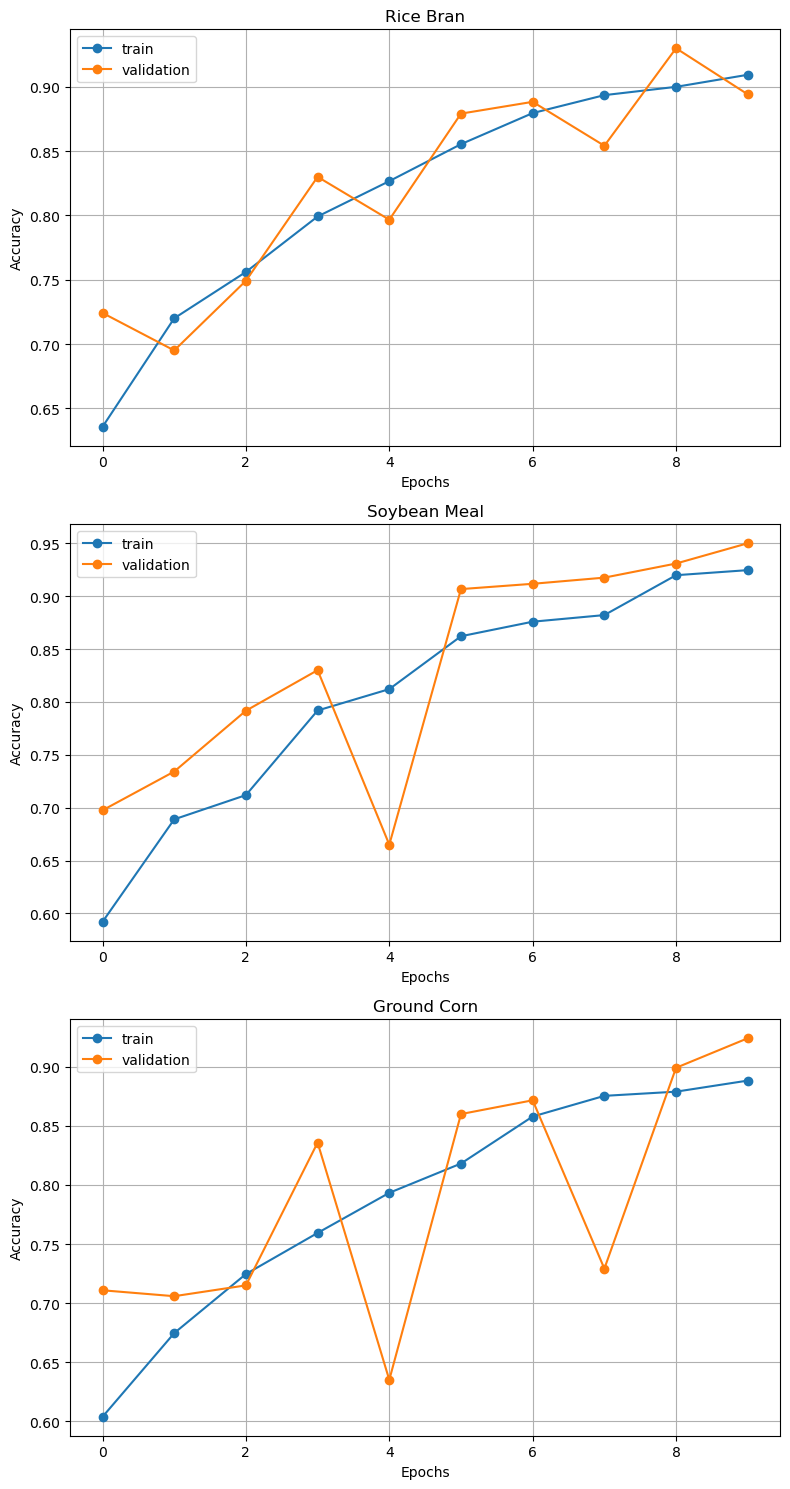

In [56]:
# Model Accuracy
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(custom_rb_history.history['accuracy'], marker='o', linestyle='-')
axes[0].plot(custom_rb_history.history['val_accuracy'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(custom_sbm_history.history['accuracy'], marker='o', linestyle='-')
axes[1].plot(custom_sbm_history.history['val_accuracy'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(custom_corn_history.history['accuracy'], marker='o', linestyle='-')
axes[2].plot(custom_corn_history.history['val_accuracy'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

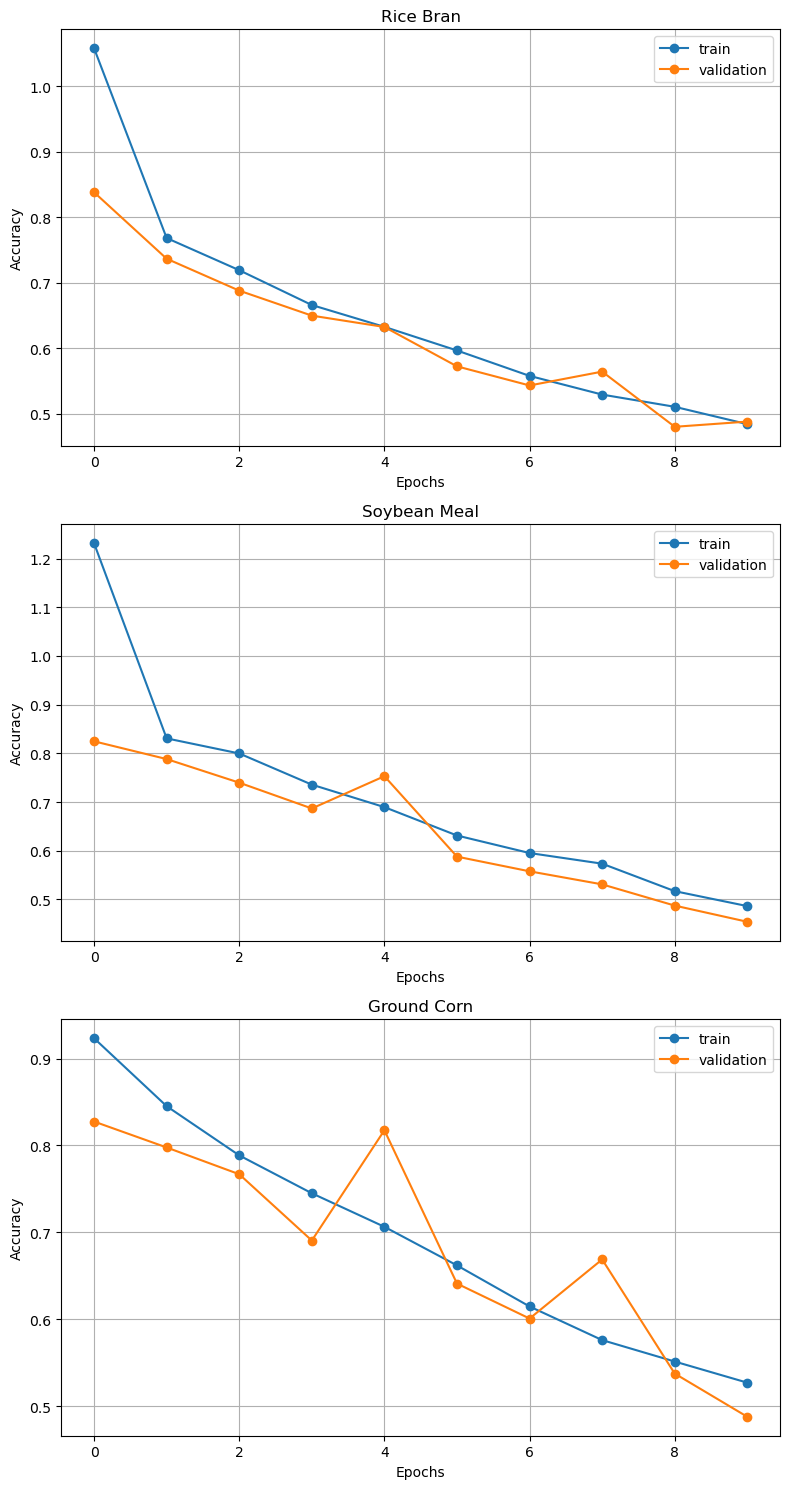

In [57]:
# Model Loss
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(custom_rb_history.history['loss'], marker='o', linestyle='-')
axes[0].plot(custom_rb_history.history['val_loss'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(custom_sbm_history.history['loss'], marker='o', linestyle='-')
axes[1].plot(custom_sbm_history.history['val_loss'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(custom_corn_history.history['loss'], marker='o', linestyle='-')
axes[2].plot(custom_corn_history.history['val_loss'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)


plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

#### Test Custom Model

RICE BRAN
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9621 - loss: 0.2791
Test Loss: 0.3810981810092926
Test Accuracy: 0.9049999713897705
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.86      0.96      0.91       300
        Pure       0.96      0.85      0.90       300

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.90       600
weighted avg       0.91      0.91      0.90       600

Precision: 0.9550561797752809
Recall: 0.85
F1 Score: 0.8994708994708994


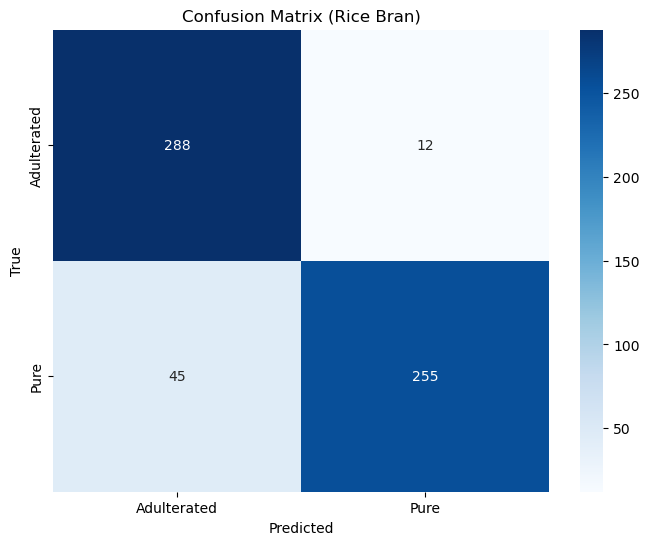

SOYBEAN MEAL
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9646 - loss: 0.4350
Test Loss: 0.4379306435585022
Test Accuracy: 0.9649999737739563
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.96      0.97      0.97       300
        Pure       0.97      0.96      0.96       300

    accuracy                           0.96       600
   macro avg       0.97      0.96      0.96       600
weighted avg       0.97      0.96      0.96       600

Precision: 0.9696969696969697
Recall: 0.96
F1 Score: 0.964824120603015


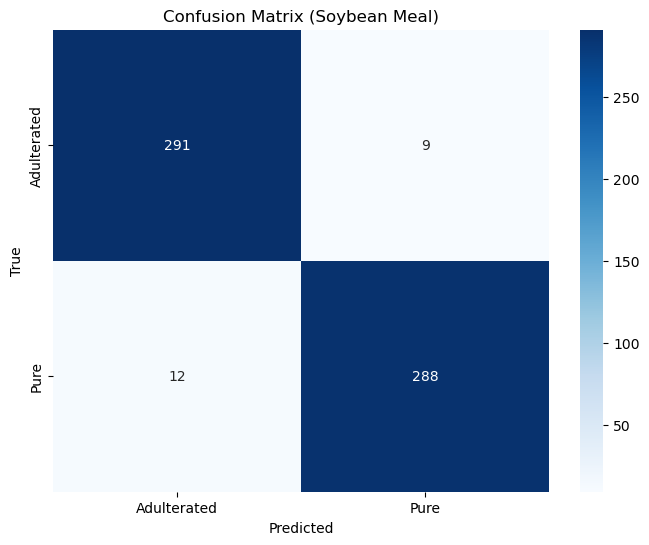

GROUND CORN
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9271 - loss: 0.4385
Test Loss: 0.560940682888031
Test Accuracy: 0.7599999904632568
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.68      1.00      0.81       300
        Pure       1.00      0.52      0.68       300

    accuracy                           0.76       600
   macro avg       0.84      0.76      0.75       600
weighted avg       0.84      0.76      0.75       600

Precision: 1.0
Recall: 0.52
F1 Score: 0.6842105263157895


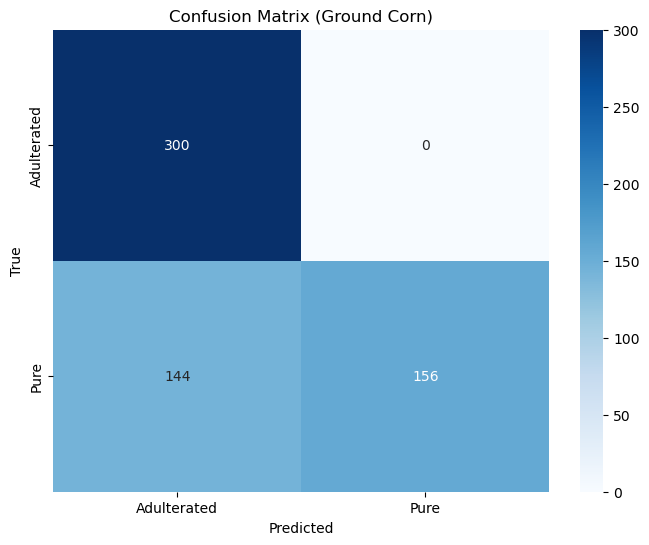

In [63]:
print('RICE BRAN')
evaluate_model(custom_rb_model, test_dir_rb, 'Rice Bran')

print('SOYBEAN MEAL')
evaluate_model(custom_sbm_model, test_dir_sbm, 'Soybean Meal')

print('GROUND CORN')
evaluate_model(custom_corn_model, test_dir_corn, 'Ground Corn')

#### ResNet-50 Model

In [26]:
def ResNetModel():
    resnet_model = Sequential()
    
    pretrained_model = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet',
    )

    # for layer in pretrained_model.layers[:-20]:
    #     layer.trainable = False

    pretrained_model.trainable = False  # Freeze ResNet layers initially

    # # num_layers = len(pretrained_model.layers)
    # # print(f"Total number of layers in ResNet50: {num_layers}")

    # # Add the layers
    resnet_model.add(pretrained_model)
    resnet_model.add(layers.GlobalAveragePooling2D())
    
    resnet_model.add(layers.BatchNormalization())
    resnet_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    resnet_model.add(layers.Dropout(0.3))
    
    resnet_model.add(layers.BatchNormalization())
    resnet_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))) # Added Dense Layer
    resnet_model.add(layers.Dropout(0.3))
    
    # # the last layer must specify how many number classes needed to evaluate
    resnet_model.add(layers.Dense(1, activation = 'sigmoid'))

    #model.summary()

    return resnet_model

ResNetModel().summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,891,969 (91.14 MB)

 Trainable params: 299,905 (1.14 MB)

 Non-trainable params: 23,592,064 (90.00 MB)

In [27]:
epoch = 15
learning_rate = 0.00001
# layers_to_train = -5

# Rice Bran
print('RICE BRAN')
resnet_rb_model = ResNetModel()
resnet_rb_history = train_data(resnet_rb_model, epoch, learning_rate, rb_data[0], rb_data[1], 2)

# Soybean Meal
print('SOYBEAN MEAL')
resnet_sbm_model = ResNetModel()
resnet_sbm_history = train_data(resnet_sbm_model, epoch, learning_rate, sbm_data[0], sbm_data[1], 2)

# Corn
print('GROUND CORN')
resnet_corn_model = ResNetModel()
resnet_corn_history = train_data(resnet_corn_model, epoch, learning_rate, corn_data[0], corn_data[1], 2)

RICE BRAN
Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.5636 - loss: 1.1297 - val_accuracy: 0.7642 - val_loss: 1.0122
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.6941 - loss: 0.9844 - val_accuracy: 0.8475 - val_loss: 0.8962
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.7981 - loss: 0.8725 - val_accuracy: 0.8958 - val_loss: 0.7932
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8454 - loss: 0.8083 - val_accuracy: 0.9158 - val_loss: 0.7227
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8794 - loss: 0.7507 - val_accuracy: 0.9292 - val_loss: 0.6740
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.9010 - loss: 0.6997 - val_accuracy: 0.9400 - val_loss: 0.6385
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9144 - loss: 0.6687 - val_accuracy: 0.9475 - val_loss: 0.6111
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 121ms/step - accuracy: 0.9158

#### Evaluate Model

In [ ]:
# 1. Get predictions (probabilities)
#train_predictions = resnet_model.predict(train_ds)
val_predictions = resnet_model.predict(validation_ds)

# 2. Convert probabilities to labels (0 or 1)
def get_true_labels(dataset):
    all_labels = []
    for x, y in dataset:  # Iterate through the dataset
        if isinstance(y, np.ndarray):  # Check if y is already a NumPy array
            all_labels.extend(y)
        else:
            all_labels.extend(np.array(y)) # Convert to numpy array if it's a list or tuple
    return np.array(all_labels)

#train_labels = get_true_labels(train_ds)
val_labels = get_true_labels(validation_ds)

train_predicted_labels = (train_predictions > 0.5).astype(int)  # Assuming binary classification
val_predicted_labels = (val_predictions > 0.5).astype(int)

# 3. Calculate and print metrics
def calculate_and_print_metrics(true_labels, predicted_labels, set_name):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, zero_division=1)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"--- {set_name} Set Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    return accuracy, precision, recall, f1

train_accuracy, train_precision, train_recall, train_f1 = calculate_and_print_metrics(train_labels, train_predicted_labels, "Training")
val_accuracy, val_precision, val_recall, val_f1 = calculate_and_print_metrics(val_labels, val_predicted_labels, "Validation")


# Print the metrics (you can customize this part)
print("\n--- Overall Results ---")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Training F1-score: {train_f1:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")

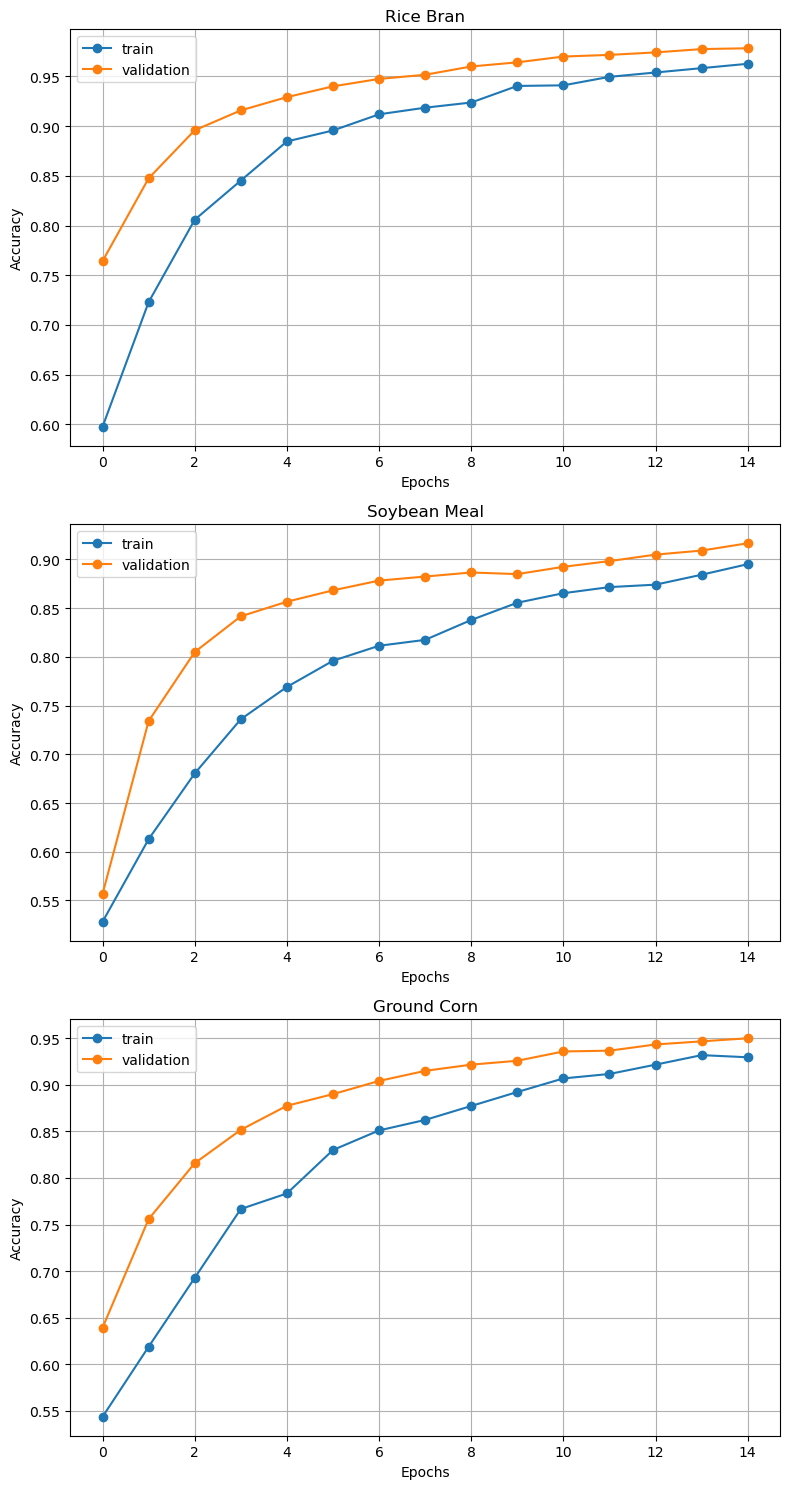

In [28]:
# Model Accuracy
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(resnet_rb_history.history['accuracy'], marker='o', linestyle='-')
axes[0].plot(resnet_rb_history.history['val_accuracy'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)


# Soybean Meal Plot
axes[1].plot(resnet_sbm_history.history['accuracy'], marker='o', linestyle='-')
axes[1].plot(resnet_sbm_history.history['val_accuracy'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)


# Ground Corn Plot
axes[2].plot(resnet_corn_history.history['accuracy'], marker='o', linestyle='-')
axes[2].plot(resnet_corn_history.history['val_accuracy'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)


plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

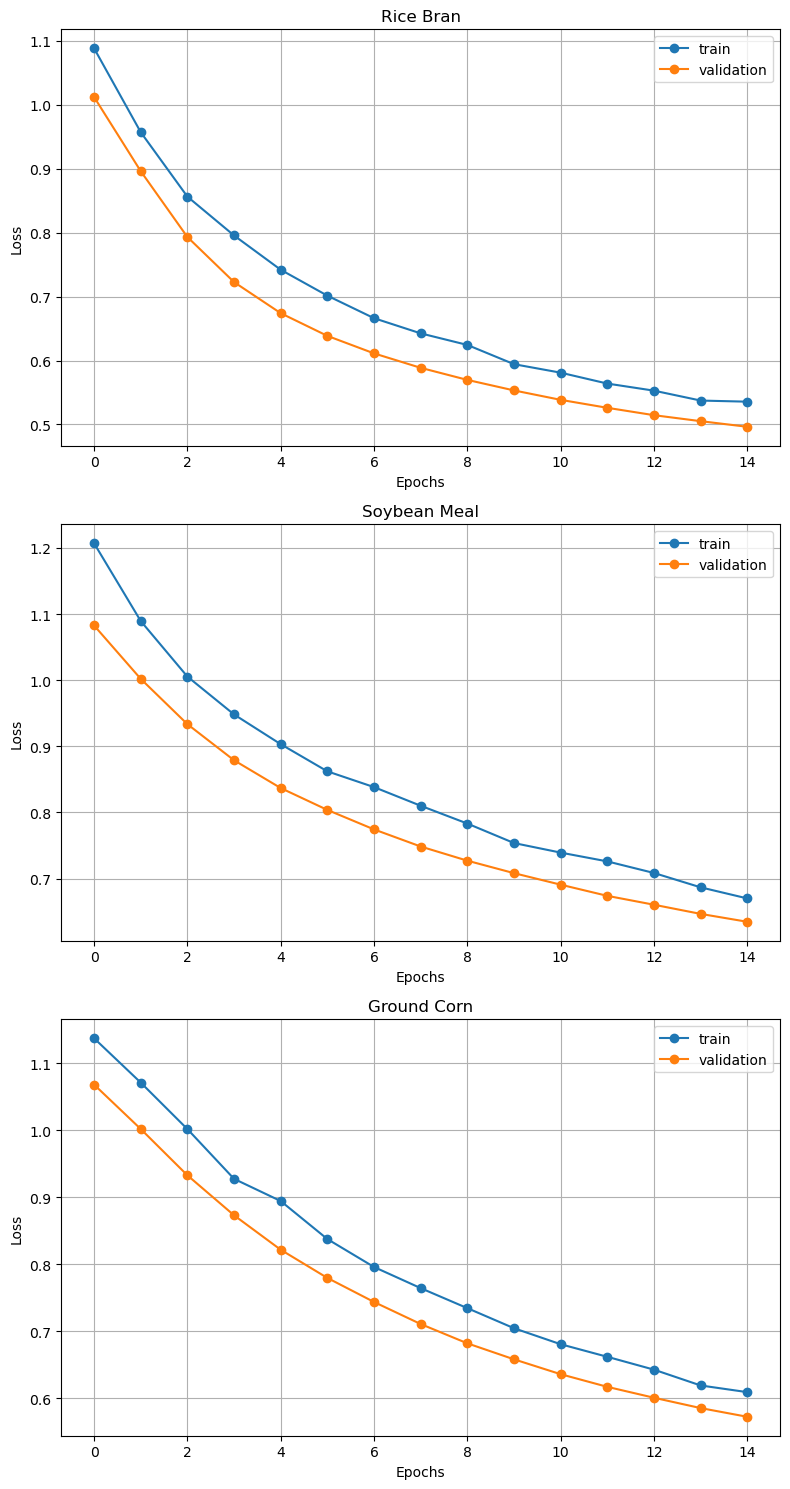

In [29]:
# Model Loss
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(resnet_rb_history.history['loss'], marker='o', linestyle='-')
axes[0].plot(resnet_rb_history.history['val_loss'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(resnet_sbm_history.history['loss'], marker='o', linestyle='-')
axes[1].plot(resnet_sbm_history.history['val_loss'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(resnet_corn_history.history['loss'], marker='o', linestyle='-')
axes[2].plot(resnet_corn_history.history['val_loss'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

#### Test ResNet Model

RICE BRAN
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.9917 - loss: 0.4423
Test Loss: 0.45232874155044556
Test Accuracy: 0.9900000095367432
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      0.98      0.99       300
        Pure       0.98      1.00      0.99       300

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600

Precision: 0.9803921568627451
Recall: 1.0
F1 Score: 0.9900990099009901


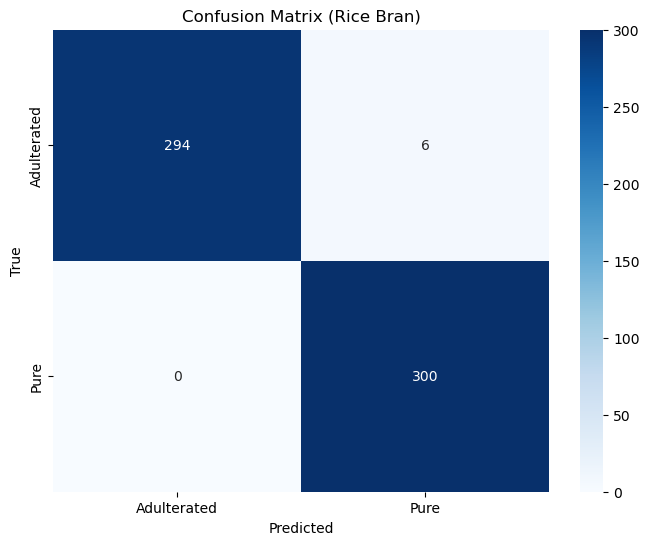

SOYBEAN MEAL
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.7997 - loss: 0.8044
Test Loss: 0.666159451007843
Test Accuracy: 0.8849999904632568
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 275ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      0.77      0.87       300
        Pure       0.81      1.00      0.90       300

    accuracy                           0.89       600
   macro avg       0.91      0.89      0.88       600
weighted avg       0.91      0.89      0.88       600

Precision: 0.8130081300813008
Recall: 1.0
F1 Score: 0.8968609865470852


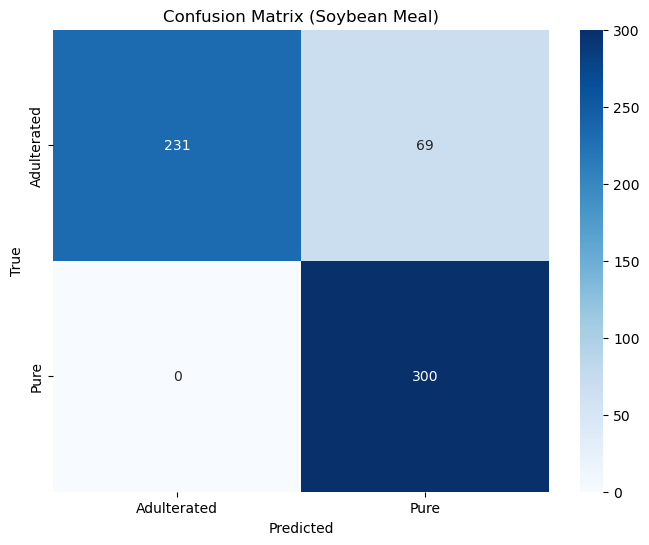

GROUND CORN
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9709 - loss: 0.5150
Test Loss: 0.5047089457511902
Test Accuracy: 0.9833333492279053
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 280ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      0.97      0.98       300
        Pure       0.97      1.00      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600

Precision: 0.967741935483871
Recall: 1.0
F1 Score: 0.9836065573770492


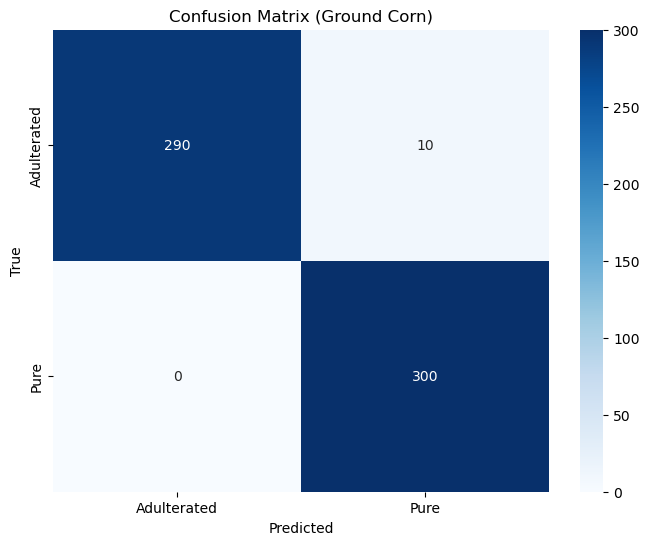

In [30]:
print('RICE BRAN')
evaluate_model(resnet_rb_model, test_dir_rb, 'Rice Bran')

print('SOYBEAN MEAL')
evaluate_model(resnet_sbm_model, test_dir_sbm, 'Soybean Meal')

print('GROUND CORN')
evaluate_model(resnet_corn_model, test_dir_corn, 'Ground Corn')

#### VGGNET Model

In [31]:
def VGG16Model():
    vgg16_model = Sequential()

    pretrained_model = tf.keras.applications.VGG16(
        include_top=False,
        input_shape=(224, 224, 3),
        weights='imagenet',
    )

    # for layer in pretrained_model.layers[:-5]:
    #     layer.trainable = False

    pretrained_model.trainable = False  # Freeze VGG16 layers initially

    vgg16_model.add(pretrained_model)
    vgg16_model.add(layers.GlobalAveragePooling2D())

    vgg16_model.add(layers.BatchNormalization())
    vgg16_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    vgg16_model.add(layers.Dropout(0.3))

    vgg16_model.add(layers.BatchNormalization())
    vgg16_model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Added Dense Layer
    vgg16_model.add(layers.Dropout(0.3))

    vgg16_model.add(layers.Dense(1, activation='sigmoid'))

    return vgg16_model

VGG16Model().summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,816,193 (56.52 MB)

 Trainable params: 100,225 (391.50 KB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [32]:
epoch = 15
learning_rate = 0.00001
# layers_to_train = -5

# Rice Bran
print("RICE BRAN")
vggnet_rb_model = VGG16Model()
vggnet_rb_history = train_data(vggnet_rb_model, epoch, learning_rate, rb_data[0], rb_data[1], 2)

# Soybean Meal
print("SOYBEAN MEAL")
vggnet_sbm_model = VGG16Model()
vggnet_sbm_history = train_data(vggnet_sbm_model, epoch, learning_rate, sbm_data[0], sbm_data[1], 2)

# Corn
print("GROUND CORN")
vggnet_corn_model = VGG16Model()
vggnet_corn_history = train_data(vggnet_corn_model, epoch, learning_rate, corn_data[0], corn_data[1], 2)

RICE BRAN
Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.5093 - loss: 1.1578 - val_accuracy: 0.6233 - val_loss: 1.0320
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 23s 156ms/step - accuracy: 0.5504 - loss: 1.1070 - val_accuracy: 0.6617 - val_loss: 0.9981
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.5985 - loss: 1.0457 - val_accuracy: 0.6883 - val_loss: 0.9655
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 158ms/step - accuracy: 0.6458 - loss: 1.0088 - val_accuracy: 0.7333 - val_loss: 0.9325
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step - accuracy: 0.6645 - loss: 0.9737 - val_accuracy: 0.7617 - val_loss: 0.9021
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 159ms/step - accuracy: 0.6864 - loss: 0.9535 - val_accuracy: 0.7842 - val_loss: 0.8747
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 162ms/step - accuracy: 0.7162 - loss: 0.9289 - val_accuracy: 0.8100 - val_loss: 0.8497
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.7380

#### Evaluate Model

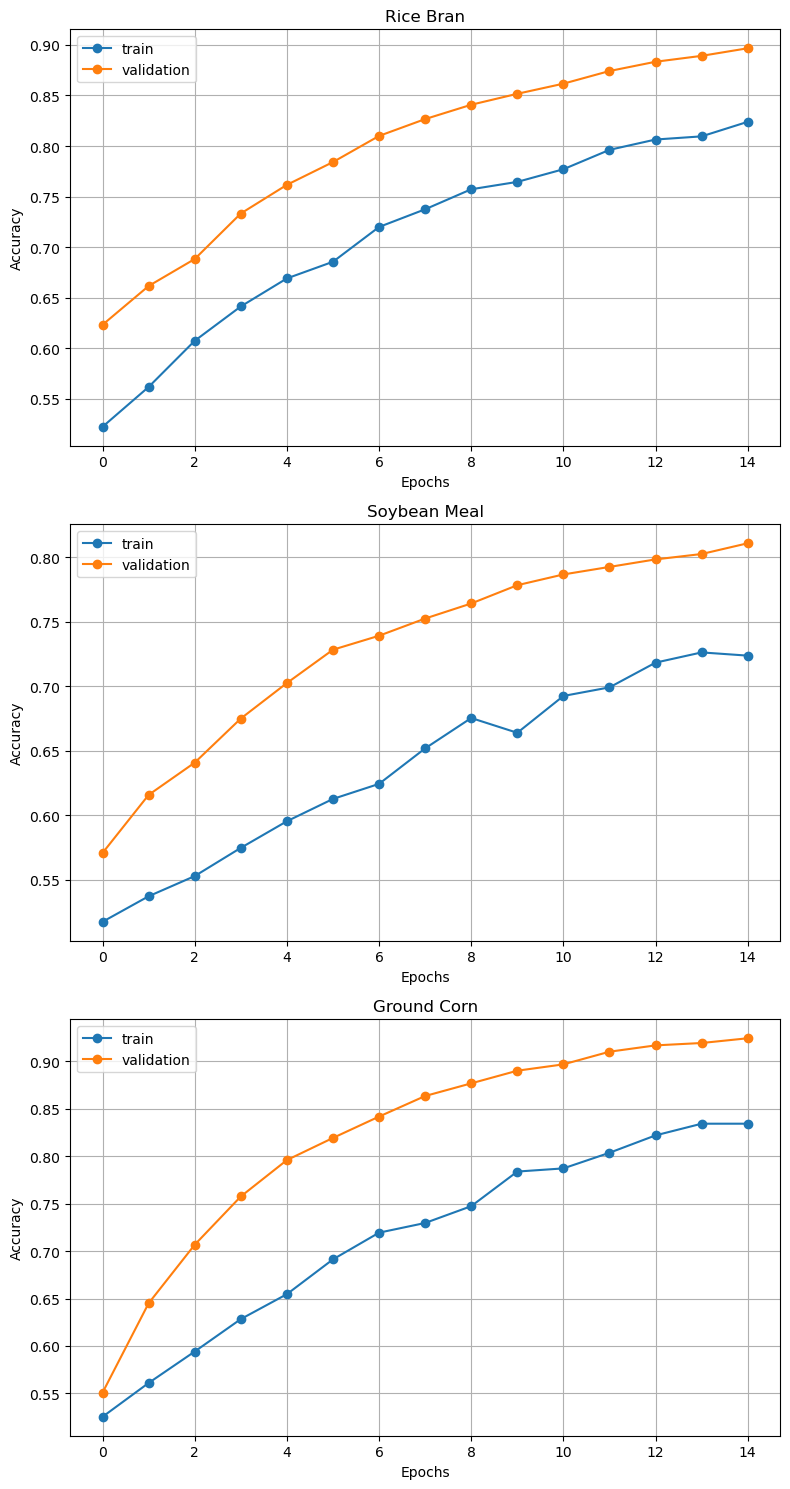

In [33]:
# Model Accuracy
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(vggnet_rb_history.history['accuracy'], marker='o', linestyle='-')
axes[0].plot(vggnet_rb_history.history['val_accuracy'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(vggnet_sbm_history.history['accuracy'], marker='o', linestyle='-')
axes[1].plot(vggnet_sbm_history.history['val_accuracy'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(vggnet_corn_history.history['accuracy'], marker='o', linestyle='-')
axes[2].plot(vggnet_corn_history.history['val_accuracy'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Accuracy')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

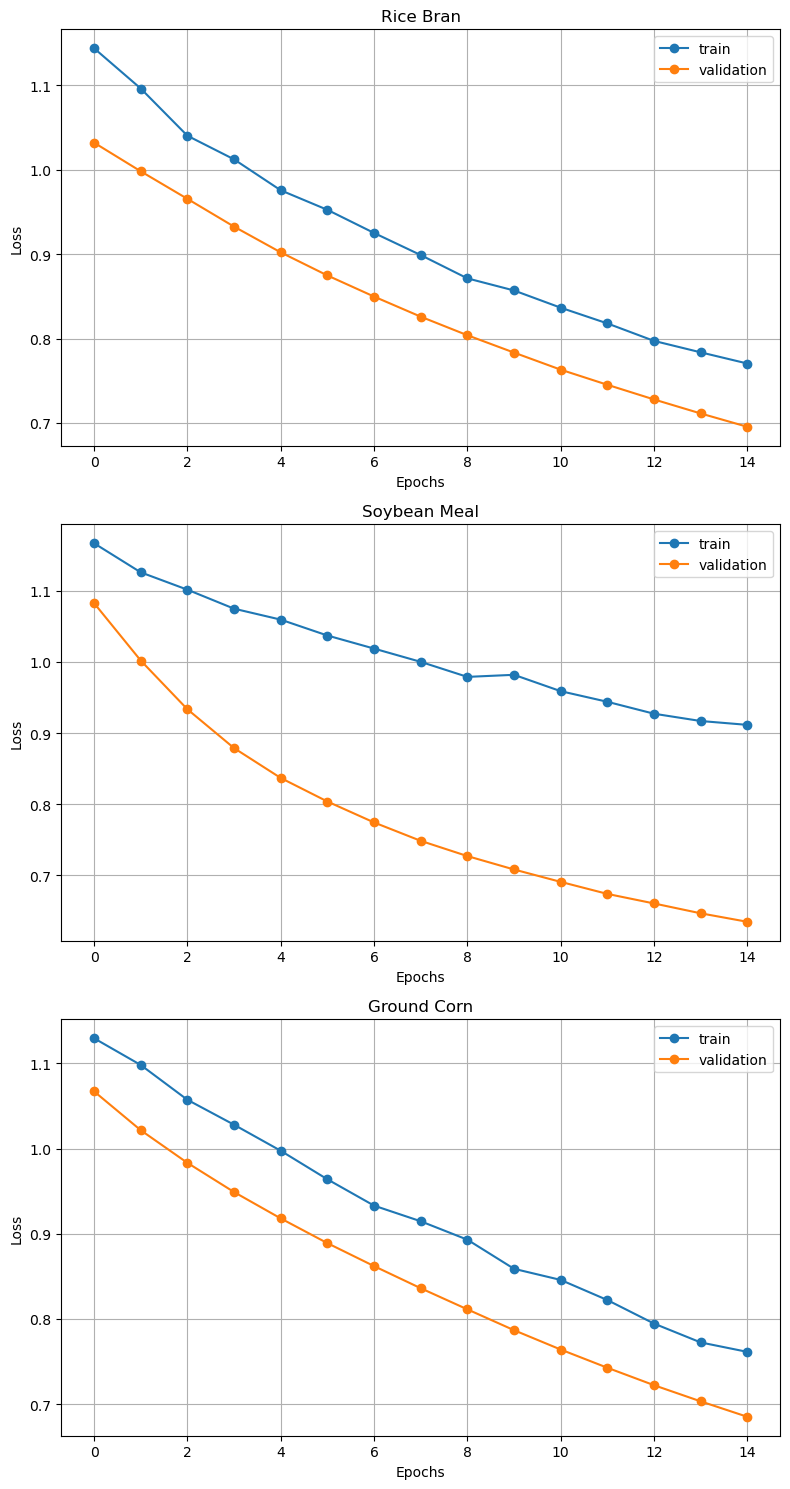

In [34]:
# Model Loss
fig, axes = plt.subplots(3, 1, figsize=(8, 15))  # 3 rows, 1 column

# Rice Bran Plot
axes[0].plot(vggnet_rb_history.history['loss'], marker='o', linestyle='-')
axes[0].plot(vggnet_rb_history.history['val_loss'], marker='o', linestyle='-')
axes[0].set_title('Rice Bran')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['train', 'validation'])
axes[0].grid(True)

# Soybean Meal Plot
axes[1].plot(vggnet_sbm_history.history['loss'], marker='o', linestyle='-')
axes[1].plot(resnet_sbm_history.history['val_loss'], marker='o', linestyle='-')
axes[1].set_title('Soybean Meal')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['train', 'validation'])
axes[1].grid(True)

# Ground Corn Plot
axes[2].plot(vggnet_corn_history.history['loss'], marker='o', linestyle='-')
axes[2].plot(vggnet_corn_history.history['val_loss'], marker='o', linestyle='-')
axes[2].set_title('Ground Corn')
axes[2].set_ylabel('Loss')
axes[2].set_xlabel('Epochs')
axes[2].legend(['train', 'validation'])
axes[2].grid(True)

plt.tight_layout() # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

#### Test VGGNet Model

RICE BRAN
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.9581 - loss: 0.5732
Test Loss: 0.572991132736206
Test Accuracy: 0.9599999785423279
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.94      0.98      0.96       300
        Pure       0.98      0.94      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600

Precision: 0.9825174825174825
Recall: 0.9366666666666666
F1 Score: 0.9590443686006825


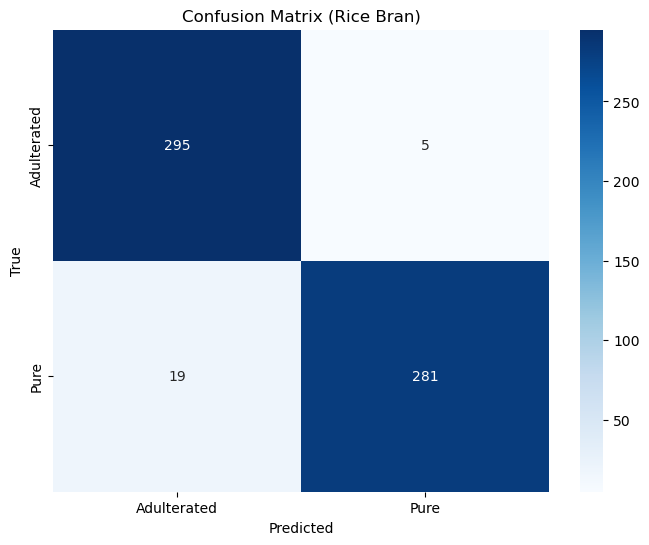

SOYBEAN MEAL
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.7148 - loss: 0.9579
Test Loss: 0.8231886625289917
Test Accuracy: 0.824999988079071
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       0.95      0.69      0.80       300
        Pure       0.76      0.96      0.85       300

    accuracy                           0.82       600
   macro avg       0.85      0.82      0.82       600
weighted avg       0.85      0.82      0.82       600

Precision: 0.7559055118110236
Recall: 0.96
F1 Score: 0.8458149779735683


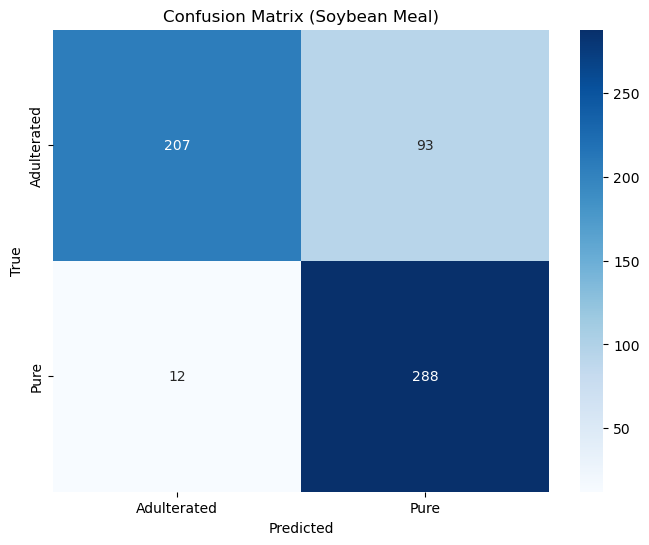

GROUND CORN
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.9986 - loss: 0.6050
Test Loss: 0.5910349488258362
Test Accuracy: 0.9983333349227905
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step
Classification Report:
              precision    recall  f1-score   support

 Adulterated       1.00      1.00      1.00       300
        Pure       1.00      1.00      1.00       300

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Precision: 0.9966777408637874
Recall: 1.0
F1 Score: 0.9983361064891847


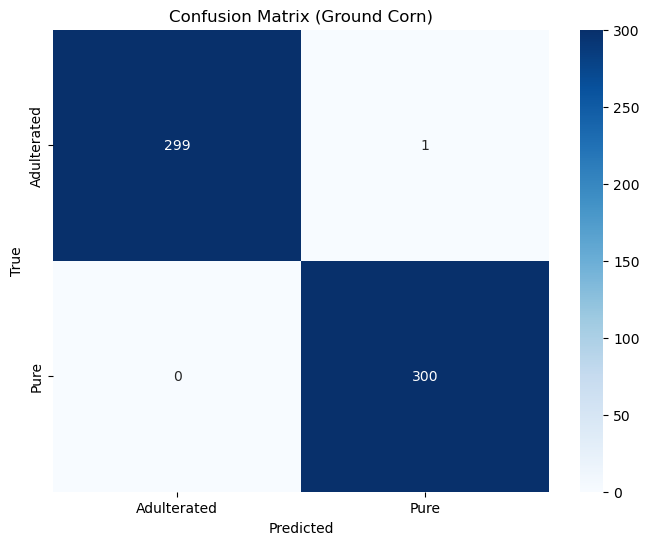

In [35]:
print('RICE BRAN')
evaluate_model(vggnet_rb_model, test_dir_rb, 'Rice Bran')

print('SOYBEAN MEAL')
evaluate_model(vggnet_sbm_model, test_dir_sbm, 'Soybean Meal')

print('GROUND CORN')
evaluate_model(vggnet_corn_model, test_dir_corn, 'Ground Corn')

### Save the Models

In [36]:
# Save the entire model
# Rice Bran
resnet_rb_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_resnet_4.h5')
#custom_rb_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_custom_1.h5')
vggnet_rb_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_vggnet_4.h5')
#custom_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Rice Bran/set3_rb_custom_7.h5')

# Soybean Meal
resnet_sbm_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Soybean Meal/set2_sbm_resnet_4.h5')
vggnet_sbm_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Soybean Meal/set2_sbm_vggnet_4.h5')

# Corn
resnet_corn_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Corn/set2_corn_resnet_4.h5')
vggnet_corn_model.save('/mnt/c/Users/Room201B/Documents/Salem - Thesis/Saved Models/Corn/set2_corn_vggnet_4.h5')